In [1]:
import os
import sys
import time
import random
import pandas as pd
from pathlib import Path
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker, power_iteration

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from side_info_decoding.utils import set_seed, load_data_from_pids, sliding_window_over_trials

seed = 666
set_seed(seed)

In [2]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 10
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=2)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

In [42]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    # "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    # "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    # '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    # '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    # '16799c7a-e395-435d-a4c4-a678007e1550',
    # '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    # '1e176f17-d00f-49bb-87ff-26d237b525f1',
    # '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

In [106]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="dg",
    # behavior="choice",
    behavior="reward",
    data_type="good_ks",
    n_t_bins = 30,
    # n_t_bins = 50,
    # align_time_type="stimOn_times",
    align_time_type="feedback_times",
    t_before=0.5,
    # t_after=1.0,
    t_after=2.0,
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367 (active: 367)
prior for this session is not found.
found 367 trials from 17.86 to 2310.69 sec.
found 7 good units in region dg


Compute spike count: 100%|██████████████████| 367/367 [00:00<00:00, 9265.80it/s]


In [107]:
pid = pids[0]
d = 0 
X, Y = X_dict[pid], Y_dict[pid]
K, C, T = X.shape
X = X.transpose(0,-1,1)

In [108]:
# preprocess data

n_R = sum(Y == 1)
n_L = sum(Y == 0)
Y_one_hot = np.zeros((len(Y), 2))
Y_one_hot[Y == 1, 1] = 1
Y_one_hot[Y == 0, 0] = 1
# Y_one_hot.T[0] /= np.sqrt(n_L)
# Y_one_hot.T[1] /= np.sqrt(n_R)
Y_one_hot.T[0] -= Y_one_hot.T[0].mean()
Y_one_hot.T[1] -= Y_one_hot.T[1].mean()


Y_c = (Y - Y.mean()).reshape(-1,1)
X_c = X - X.mean()

### closed-form reduced-rank

In [109]:
R = 3

In [110]:
S_t = np.einsum("ktc,kdn->ctdn", X_c, X_c)
core, factors = tucker(S_t, rank=[R, T, T, R])
core.mean()

5.610453154163408

In [111]:
def reduced_rank_close_form(X_c, Y_c, R, penalty):
    
    # compute U
    S_t = np.einsum("ktc,kdn->ctdn", X_c, X_c)
    
    I = np.eye(C*T)
    np.fill_diagonal(I, penalty)
    I = I.reshape(C, T, T, C)
    S_t = S_t + I
    
    D = np.eye(C*T)
    np.fill_diagonal(D, 1/np.diag(S_t.reshape(C*T, T*C)))
    D = np.sqrt(D).reshape(C,T,T,C)

    XY = (X_c.T @ Y_c).reshape(C,T)
    XYD = np.einsum("ct,ctdn->nd", XY, D)
                     
    U, _, _ = np.linalg.svd(XY)
    U = U[:,:R]
    
    fig, axes = plt.subplots(1, 1, figsize=(4,2))
    axes.imshow(U.T, aspect="auto", cmap="coolwarm")
    plt.tight_layout()
    plt.show()
    
    # compute V
    G_part = np.einsum("cr, ctdn->rtdn", U, S_t)
    G = np.einsum("rtdn, ns->rs", G_part, U)
    H = U.T @ (X_c.T @ Y_c).squeeze()
    V = np.linalg.inv(G) @ H
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,2))
    ax1.imshow(V, aspect="auto", cmap="coolwarm")
    ax2.plot(V.T)
    plt.tight_layout()
    plt.show()
    
    return U, V

In [112]:
def reduced_rank_close_form(X_c, Y_c, R, penalty):
    
    # compute U
    S_b = np.einsum("ndk,ktc->ndtc", (X_c.T @ (Y_c @ Y_c.T)), X_c)
    S_t = np.einsum("ktc,kdn->ctdn", X_c, X_c)
    
    I = np.eye(np.diag(S_t.reshape(C*T, T*C)).shape[0])
    np.fill_diagonal(I, penalty)
    I = I.reshape(C, T, T, C)
    S_t = S_t + I
    
    inv_S_t = np.eye(np.diag(S_t.reshape(C*T, T*C)).shape[0])
    np.fill_diagonal(inv_S_t, 1/np.diag(S_t.reshape(C*T, T*C)))
    inv_S_t = inv_S_t.reshape(C, T, T, C)
    inv_S_t_S_b = np.einsum("ctdn,ndab->ctab", inv_S_t, S_b)
    # inv_S_t = np.linalg.pinv(S_t)
    # inv_S_t_S_b = np.einsum("ctnd,ndab->ctab", inv_S_t, S_b)
    core, factors = tucker(inv_S_t_S_b, rank=[R, R, R, R])
    
    fig, axes = plt.subplots(1, 4, figsize=(12,2))
    for i in range(len(factors)):
        axes[i].imshow(factors[i].T, aspect="auto", cmap="coolwarm")
    plt.tight_layout()
    plt.show()
    
    U = factors[-1] 
    
    # compute V
    G_part = np.einsum("cr, ctdn->rtdn", U, S_t)
    G = np.einsum("rtdn, ns->rs", G_part, U)
    H = U.T @ (X_c.T @ Y_c).squeeze()
    V = np.linalg.inv(G) @ H
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,2))
    ax1.imshow(V, aspect="auto", cmap="coolwarm")
    ax2.plot(V.T)
    plt.tight_layout()
    plt.show()
    
    return U, V

In [113]:
X_train, X_test, Y_train, Y_test = train_test_split(X_c, Y_c, test_size=0.2, random_state=seed)

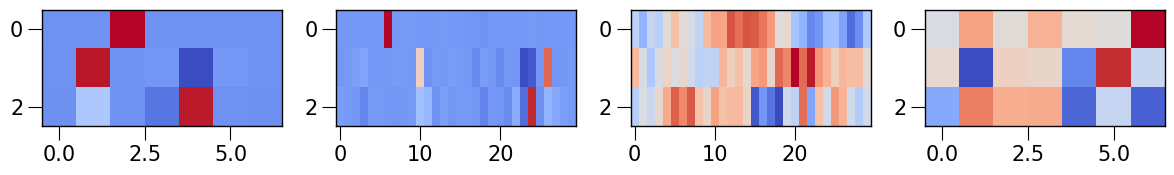

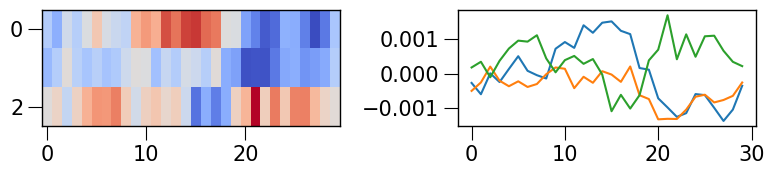

In [114]:
U, V = reduced_rank_close_form(X_train, Y_train, R=3, penalty=core.mean())

In [115]:
_, _, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [116]:
Yhat_train = np.einsum("ktr,rt->k", X_train @ U, V) 
Yhat_test = np.einsum("ktr,rt->k", X_test @ U, V) 
roc_auc_score(Y_test, Yhat_test)

0.9074573225516622

In [117]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1e4)
clf.fit(Yhat_train.reshape(-1,1), Y_train)
Yhat = clf.predict(Yhat_test.reshape(-1,1))
prob = clf.predict_proba(Yhat_test.reshape(-1,1))[:,1]
roc_auc_score(Y_test, prob)

0.9074573225516622

In [118]:
balanced_accuracy_score(Y_test, Yhat)

0.8858939802336029

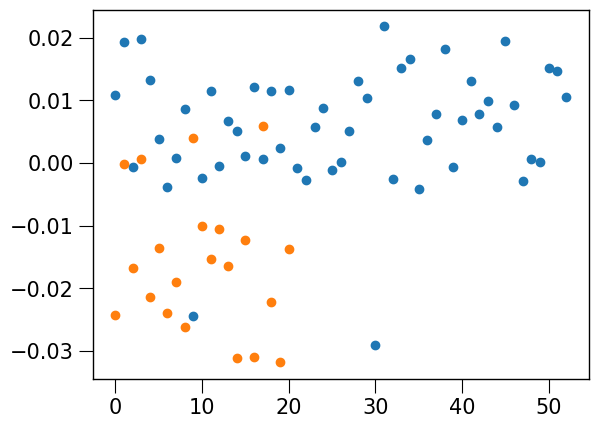

In [119]:
plt.scatter(range(len(Yhat_test[Y_test==1])), Yhat_test[Y_test==1])
plt.scatter(range(len(Yhat_test[Y_test==0])), Yhat_test[Y_test==0]);

In [120]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [121]:
clf = LogisticRegression(C=0.1).fit(X_train.reshape((-1,T*C)), Y_train)
yhat = clf.predict(X_test.reshape((-1,T*C)))
prob = clf.predict_proba(X_test.reshape((-1,T*C)))
roc_auc_score(Y_test, prob[:,1])

0.8706199460916442

In [122]:
balanced_accuracy_score(Y_test, yhat)

0.8337825696316262

#### cross-validation

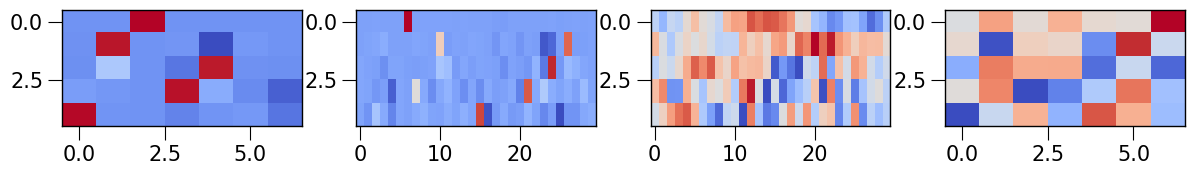

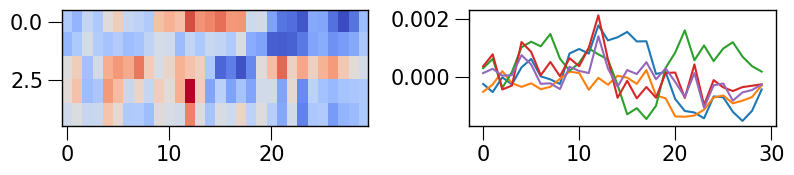

reduced-rank:  0.8382749326145553 0.9398023360287512
baseline:  0.8144654088050314 0.9056603773584906


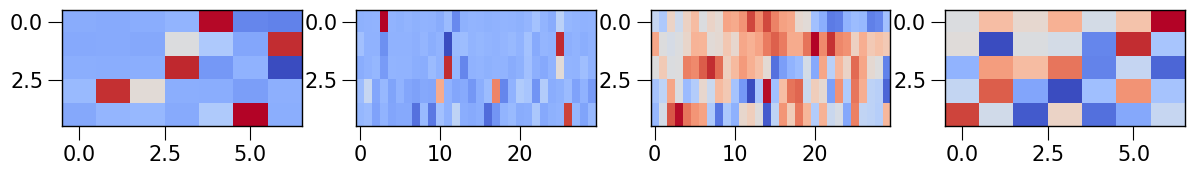

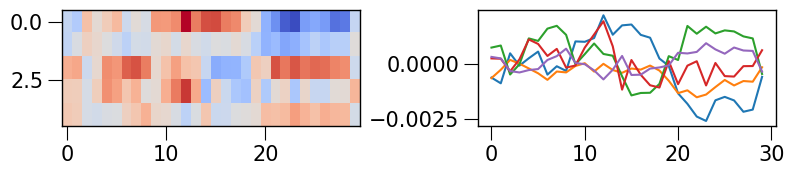

reduced-rank:  0.6865079365079365 0.7777777777777778
baseline:  0.621031746031746 0.7738095238095238


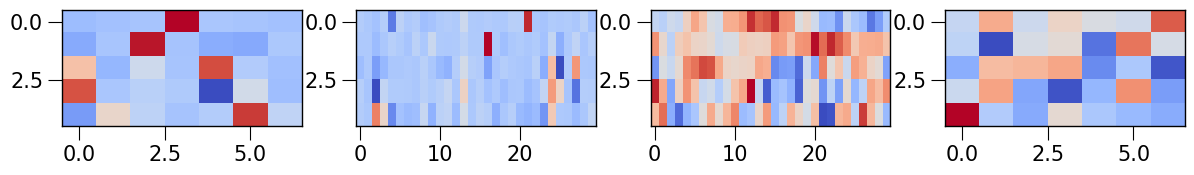

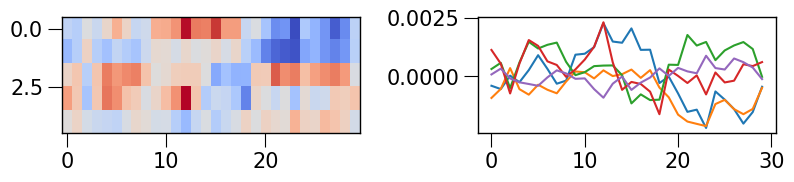

reduced-rank:  0.87590799031477 0.9116222760290557
baseline:  0.812953995157385 0.923728813559322


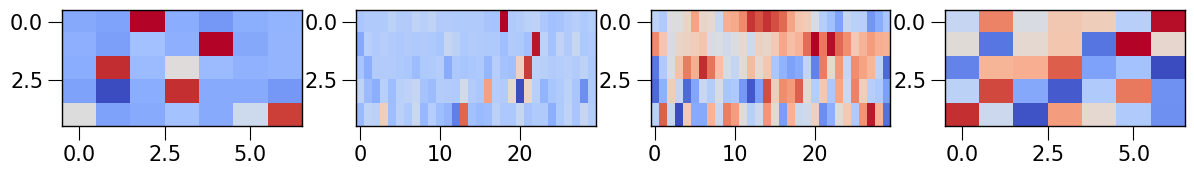

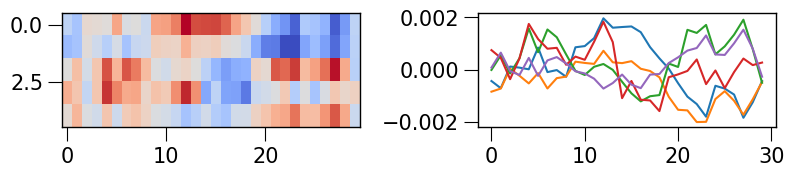

reduced-rank:  0.780214424951267 0.8762183235867447
baseline:  0.7353801169590644 0.8966861598440546


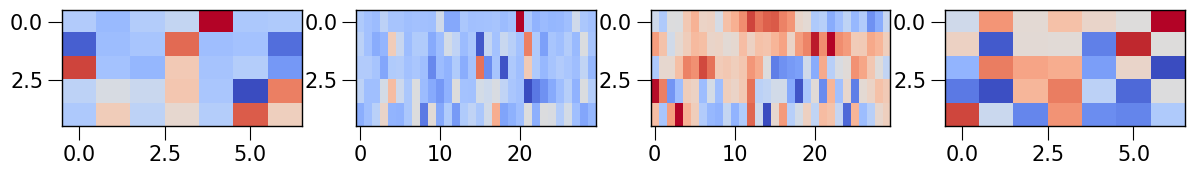

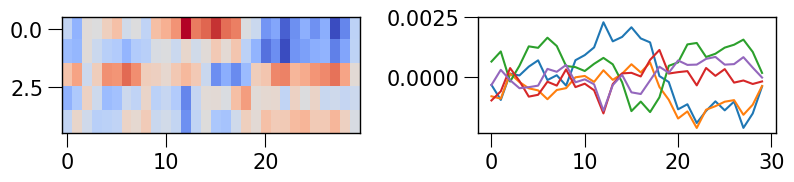

reduced-rank:  0.7741379310344827 0.8919540229885057
baseline:  0.7666666666666666 0.9137931034482759


In [123]:
n_folds = 5

penalty = [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000]

baseline_accs, baseline_aucs = [], []
rrr_accs, rrr_aucs = [], []
# skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
skf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train, test in skf.split(X, Y):
    X_train, X_test, Y_train, Y_test = X_c[train], X_c[test], Y_c[train], Y_c[test]
    U, V = reduced_rank_close_form(X_train, Y_train, R=5, penalty=core.mean())
    Y_train, Y_test = Y[train], Y[test]
    Yhat_train = np.einsum("ktr,rt->k", X_train @ U, V)
    Yhat_test = np.einsum("ktr,rt->k", X_test @ U, V)
    
    decoder = GridSearchCV(LogisticRegression(), {"C": penalty})
    decoder.fit(Yhat_train.reshape(-1,1), Y_train)
    Yhat = decoder.predict(Yhat_test.reshape(-1,1))
    
    acc = balanced_accuracy_score(Y_test, Yhat)
    auc = roc_auc_score(Y_test, Yhat_test)
    print("reduced-rank: ", acc, auc)
    rrr_accs.append(acc)
    rrr_aucs.append(auc)
    X_train, X_test, Y_train, Y_test = X[train], X[test], Y[train], Y[test]
    decoder = GridSearchCV(LogisticRegression(), {"C": penalty})
    decoder.fit(X_train.reshape((-1,T*C)), Y_train)
    yhat = decoder.predict(X_test.reshape((-1,T*C)))
    prob = decoder.predict_proba(X_test.reshape((-1,T*C)))[:,1]
    acc = balanced_accuracy_score(Y_test, yhat)
    auc = roc_auc_score(Y_test, prob)
    baseline_accs.append(acc)
    baseline_aucs.append(auc)
    print("baseline: ", acc, auc)

In [124]:
print(f"5-fold CV reduced-rank acc: {np.mean(rrr_accs):.3f} auc: {np.mean(rrr_aucs):.3f}")
print(f"5-fold CV baseline acc: {np.mean(baseline_accs):.3f} auc: {np.mean(baseline_aucs):.3f}")

5-fold CV reduced-rank acc: 0.791 auc: 0.879
5-fold CV baseline acc: 0.750 auc: 0.883


In [273]:
# rrr_per_pids, baseline_per_pids = {}, {}

In [274]:
rrr_per_pids.update({pid: [np.mean(rrr_accs), np.mean(rrr_aucs)]})
baseline_per_pids.update({pid: [np.mean(baseline_accs), np.mean(baseline_aucs)]})

In [275]:
rrr_per_pids

{'dab512bd-a02d-4c1f-8dbc-9155a163efc0': [0.6557231651553902,
  0.7425643648763852],
 'febb430e-2d50-4f83-87a0-b5ffbb9a4943': [0.7570787364905012,
  0.8368393794864382],
 '84bb830f-b9ff-4e6b-9296-f458fb41d160': [0.6750494687486557,
  0.7553920936034757],
 '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a': [0.780488383119962,
  0.8644960038274407],
 '143dd7cf-6a47-47a1-906d-927ad7fe9117': [0.5851640026640027,
  0.6237442860170133],
 '16799c7a-e395-435d-a4c4-a678007e1550': [0.6846408347189088,
  0.7752140212213949],
 '1a60a6e1-da99-4d4e-a734-39b1d4544fad': [0.7379725678000046,
  0.82557329586956],
 '1e176f17-d00f-49bb-87ff-26d237b525f1': [0.5937983193277312,
  0.6158636788048553],
 '31f3e083-a324-4b88-b0a4-7788ec37b191': [0.8278718364734349,
  0.915812969632632]}

In [276]:
baseline_per_pids

{'dab512bd-a02d-4c1f-8dbc-9155a163efc0': [0.6119882197938464,
  0.6119882197938464],
 'febb430e-2d50-4f83-87a0-b5ffbb9a4943': [0.7167365226188755,
  0.7167365226188755],
 '84bb830f-b9ff-4e6b-9296-f458fb41d160': [0.6824117090377253,
  0.6824117090377253],
 '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a': [0.7125968073336495,
  0.7125968073336495],
 '143dd7cf-6a47-47a1-906d-927ad7fe9117': [0.5895304695304696,
  0.5895304695304696],
 '16799c7a-e395-435d-a4c4-a678007e1550': [0.6171387262343672,
  0.6171387262343672],
 '1a60a6e1-da99-4d4e-a734-39b1d4544fad': [0.7830682594660823,
  0.7830682594660823],
 '1e176f17-d00f-49bb-87ff-26d237b525f1': [0.54290756302521, 0.54290756302521],
 '31f3e083-a324-4b88-b0a4-7788ec37b191': [0.8491428625657182,
  0.8491428625657184]}

In [279]:
auc_baseline, auc_rrr = [], []
for key in baseline_per_pids.keys():
    auc_baseline.append(baseline_per_pids[key][-1])
    auc_rrr.append(rrr_per_pids[key][-1])

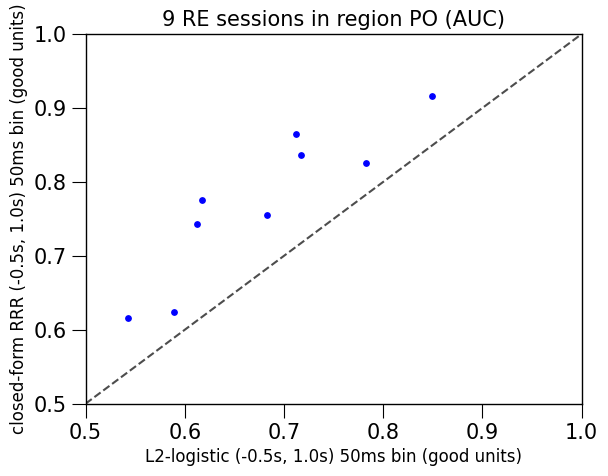

In [281]:
import matplotlib.pyplot as plt
plt.scatter(auc_baseline, auc_rrr, c="blue", s=15)
plt.xlim(0.5, 1.0)
plt.ylim(0.5, 1.0)
plt.xlabel("L2-logistic (-0.5s, 1.0s) 50ms bin (good units)", fontsize=12)
plt.ylabel("closed-form RRR (-0.5s, 1.0s) 50ms bin (good units)", fontsize=12)
plt.plot([0.5, 1.0], [0.5, 1.0], ls="--", c=".3")
plt.title("9 RE sessions in region PO (AUC)");

### closed-form multi-task reduced-rank